# Problem 1
A micrometeorologist is making measurements of surface energy fluxes using the Eddy Correlation method applied above an area of short grass with an albedo of 23% growing in a wet clay soil with 40% porosity. During one particular hour her instruments provide the measurements of the vertical wind speed, w, air temperature, T, and specific humidity, q, every minute given in the table below. See Chapter 7 of Terrestrial Hydrometeorology, and note that fluctuations in the variables are the difference between the current value (at each second in this case) and the time average value over the hour. 

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pint
ureg = pint.UnitRegistry()


In [139]:
#Variables given in initial problem statement
albedo = 0.23
porosity = 0.40

#Variables given in 1c
rho_a = 1.28 #kg m-3 density of air 
LH = 2.45 * 10**6 # J kg-1 latent heat of vaporization
c_p = 1.01 * 10**3 # J kg-1 K-1 specific heat of air at constant pressure 
P = 100 * 1000 # Pa atmospheric pressure given in email from Antonio

#import data from problem statement
obs_data_fn = r"C:\Users\adunw\OneDrive - Colostate\Fort Collins\Courses\Spring 2024\CIVE 625\Homework\HW_2\Problem 1 Data.xlsx"
obs_data = pd.read_excel(obs_data_fn)
# Delete second row that contains units
obs_data = obs_data.drop(0)

#Add units to the data without changing the column names
#Column names: Time	w	T	q
#Data Units: (min)	(m s-1)	(deg C)	(kg kg-1)

obs_data['Time'] = obs_data['Time'].astype(float)
obs_data['w'] = obs_data['w'].astype(float)
obs_data['T'] = obs_data['T'].astype(float)
obs_data['q'] = obs_data['q'].astype(float)

#Attach units to the data without changing data type or column names
# Define the units for each column
units = {'Time': 'min', 'w': 'm / s', 'T': 'deg C', 'q': 'kg / kg'}

# Attach units as metadata to the DataFrame
obs_data.attrs['units'] = units

def print_df_with_units(df):
    # Check if units metadata exists
    if 'units' in df.attrs:
        # Print the DataFrame
        print(df)
        # Print the units
        print("\nUnits:")
        for column, unit in df.attrs['units'].items():
            print(f"{column}: {unit}")
    else:
        # Just print the DataFrame if no units metadata is found
        print(df)

# Example usage
print_df_with_units(obs_data)




    Time     w       T        q
1    0.5  0.21  19.941  0.05197
2    1.5 -0.15  18.982  0.05019
3    2.5 -0.44  19.438  0.05086
4    3.5 -0.78  18.219  0.05041
5    4.5  0.39  20.860  0.04893
6    5.5 -1.96  19.305  0.05008
7    6.5  0.99  19.814  0.04716
8    7.5 -0.02  17.800  0.04971
9    8.5 -0.62  21.357  0.05026
10   9.5 -0.73  19.228  0.05066
11  10.5 -0.81  19.042  0.04979
12  11.5 -0.09  19.002  0.04934
13  12.5  1.40  19.382  0.05169
14  13.5 -0.57  20.159  0.05012
15  14.5  0.08  19.401  0.05012
16  15.5  1.69  20.400  0.05096
17  16.5  0.56  20.917  0.05006
18  17.5  0.37  21.537  0.05037
19  18.5  0.21  21.168  0.05215
20  19.5  0.71  21.730  0.04994
21  20.5  0.36  20.900  0.04950
22  21.5 -0.88  20.673  0.05105
23  22.5 -0.95  20.082  0.04942
24  23.5  0.93  20.089  0.04974
25  24.5 -1.86  20.733  0.04987
26  25.5  0.61  18.429  0.04923
27  26.5 -0.54  20.574  0.04995
28  27.5  0.86  19.094  0.05035
29  28.5  0.60  20.576  0.04966
30  29.5  0.09  21.079  0.05168
31  30.5

## Problem 1a
### (a)	Plot the minute-by-minute values of w' in m/s, Tv' in deg C and q’ in kg/kg calculated by the micrometeorologist from these data. (30 points)

Obs_data_fn has time, s, vertical wind speed, w, air temperature, T, and specific humidity, q

fluctuations in the variables = current value (at each minute in this case) - time average value over the hour

In [140]:
def calc_virtual_temp(temp, specific_humidity):
    """
    Calculate virtual temperature
    :param temp: temperature in K
    :param specific_humidity: specific humidity in g/kg
    :return: virtual temperature in K
    """

    virtual_temp = temp * (1 + (0.61 * specific_humidity)) # Eq. (2.14) TH
    return virtual_temp

def calc_virtual_potential_temp(virt_temp, P, Ra):
    """
    Calculate virtual potential temperature
    :const c_p: specific heat of air at constant pressure in J/(kg K)
    :param virt_temp: virtual temperature in K
    :param pressure: pressure in Pa
    :param R_a: gas constant for dry air in J/(kg K)
    :return: virtual potential temperature in K
    """
    #converted to Pa -> 100000 Pa = 100 kPa
    virt_pot_temp = virt_temp * (100000/P)**(Ra/c_p) # Eq. (3.18) TH
    return virt_pot_temp

def calc_Ra(rho_a, P, T):
    """
    Calculate gas constant for dry air
    :param rho_a: density of air in kg/m^3
    :param P: pressure in kPa
    :param T: temperature in K
    :return: gas constant for dry air in J/(kg K)
    """
    Ra = P / rho_a / T # Ideal Gas Law
    return Ra


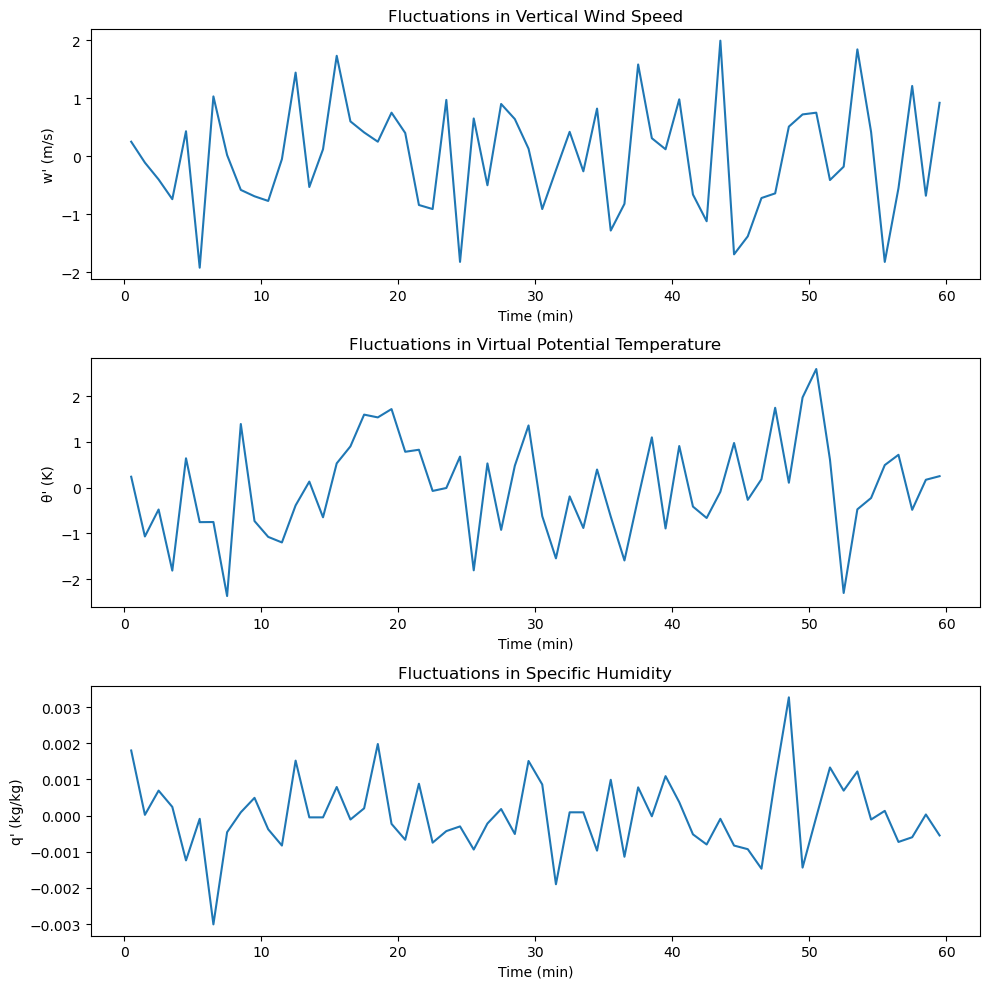

In [141]:

obs_data['T'] = obs_data['T'] + 273.15 # Convert to K
obs_data['Tv'] = calc_virtual_temp(obs_data['T'], obs_data['q'])
obs_data['Ra'] = calc_Ra(rho_a, P, obs_data['T']) # Calculate gas constant for moist air given variable T and constant density and pressure
obs_data['theta'] = calc_virtual_potential_temp(obs_data['Tv'], P, obs_data['Ra']) # Virtual potential temperature in K

#Calculate the time average values of w, T, and q
w_bar = obs_data['w'].mean()
theta_bar = obs_data['theta'].mean()
q_bar = obs_data['q'].mean()

#Create new columns for the fluctuations in w (wind speed), theta (virtual potential temp), and q (specific humidity)
obs_data['w_prime'] = obs_data['w'] - w_bar
obs_data['theta_prime'] = obs_data['theta'] - theta_bar
obs_data['q_prime'] = obs_data['q'] - q_bar

#Plot the minute-by-minute values of w' in m s-1, Tv' in deg C, and q' in kg kg-1
fig, ax = plt.subplots(3,1, figsize=(10,10))
ax[0].plot(obs_data['Time'], obs_data['w_prime'])
ax[0].set_ylabel("w' (m/s)")
ax[0].set_xlabel("Time (min)")
ax[0].set_title("Fluctuations in Vertical Wind Speed")
ax[1].plot(obs_data['Time'], obs_data['theta_prime'])
ax[1].set_ylabel("θ' (K)")
ax[1].set_xlabel("Time (min)")
ax[1].set_title("Fluctuations in Virtual Potential Temperature")
ax[2].plot(obs_data['Time'], obs_data['q_prime'])
ax[2].set_ylabel("q' (kg/kg)")
ax[2].set_xlabel("Time (min)")
ax[2].set_title("Fluctuations in Specific Humidity")
plt.tight_layout()
plt.show()


# Problem 1b

(b)	Plot the minute-by-minute values of the product (w'Tv') in m s-1 (deg C) and (w'q') in m s-1 kg kg-1 calculated by the micrometeorologist from these data. (20 points)

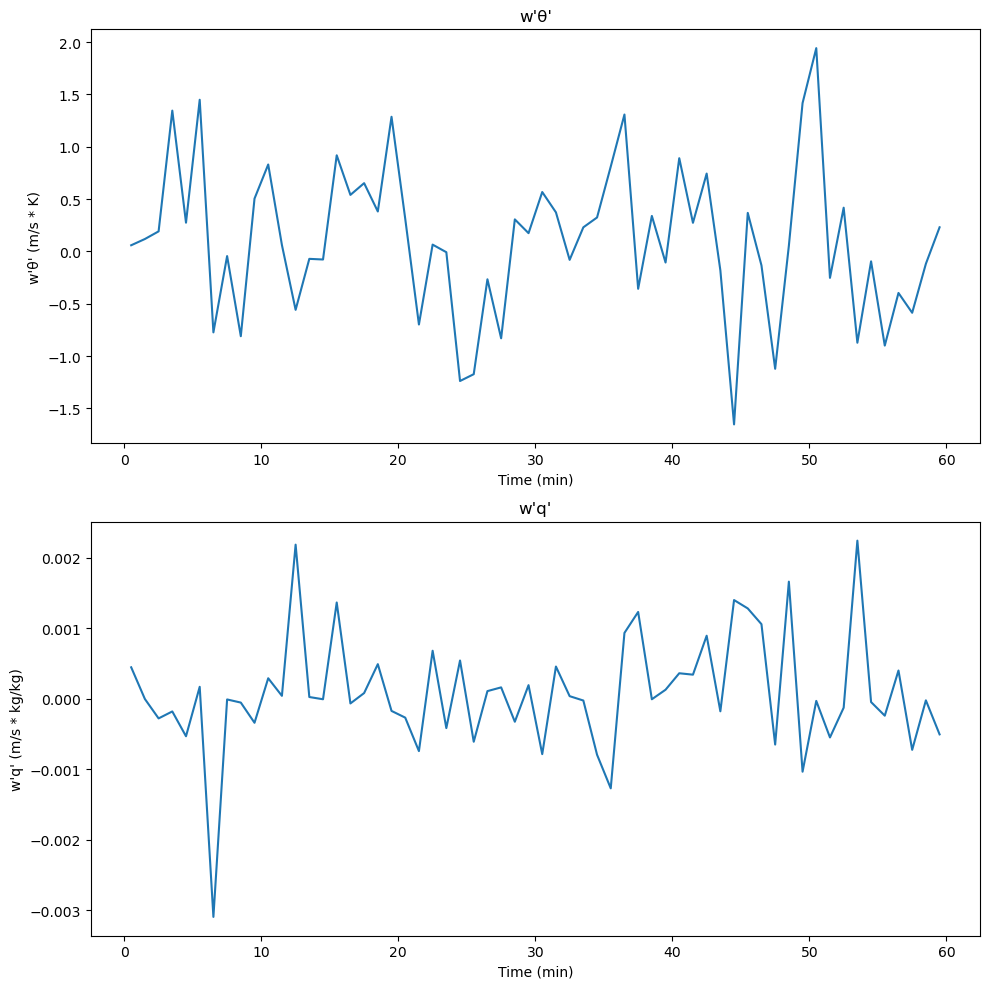

In [142]:
obs_data['w_prime x theta_prime'] = obs_data['w_prime'] * obs_data['theta_prime'] # w'θ' in m/s * K, multiply before averaging
obs_data['w_prime x q_prime'] = obs_data['w_prime'] * obs_data['q_prime'] # w'q' in m/s * kg/kg, multiply before averaging

fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].plot(obs_data['Time'], obs_data['w_prime x theta_prime'])
ax[0].set_ylabel("w'θ' (m/s * K)")
ax[0].set_xlabel("Time (min)")
ax[0].set_title("w'θ'")
ax[1].plot(obs_data['Time'], obs_data['w_prime x q_prime'])
ax[1].set_ylabel("w'q' (m/s * kg/kg)")
ax[1].set_xlabel("Time (min)")
ax[1].set_title("w'q'")
plt.tight_layout()
plt.show()


# Problem 1c
(c)	Assuming the density of air rho_a = 1.28 kg m-3, the latent heat of vaporization of water lambda = 2.45 MJ kg-1, and specific heat of air at constant pressure cp = 1.01 kJ kg-1, what are the hourly average values of sensible heat, H, and latent heat flux, E, (both in units of W m-2) that he calculated from these measurements? (20 points)

In [143]:


w_prime_theta_prime_bar = obs_data['w_prime x theta_prime'].mean() 
w_prime_q_prime_bar = obs_data['w_prime x q_prime'].mean()
LH_flux = rho_a * LH * w_prime_q_prime_bar # Eq. 7.7 in TH
SH_flux = rho_a * c_p * w_prime_theta_prime_bar # Eq. 7.8 in TH

print(f"w'theta' average: {w_prime_theta_prime_bar:.2f}")
print(f"w'q' average: {w_prime_q_prime_bar:.2e}")
print(f"Time Averaged Latent Heat Flux: {LH_flux:.2f} W/m^2")
print(f"Time Averaged Sensible Heat Flux: {SH_flux:.2f} W/m^2")


w'theta' average: 0.11
w'q' average: 8.66e-05
Time Averaged Latent Heat Flux: 271.69 W/m^2
Time Averaged Sensible Heat Flux: 137.60 W/m^2



# Problem 1d
(d)	What value of sensible heat would he have calculated had he for simplicity assumed the virtual temperature of the air, Tv, was always equal to the air temperature, T? Can you explain this result? (10 points)


In [144]:
obs_data['theta_T'] = calc_virtual_potential_temp(obs_data['T'], P, obs_data['Ra']) # Virtual potential temperature in K, using T instead of Tv
theta_T_bar = obs_data['theta_T'].mean()
obs_data['theta_T_prime'] = obs_data['theta_T'] - theta_T_bar
obs_data['w_prime x theta_T_prime'] = obs_data['w_prime'] * obs_data['theta_T_prime']

w_prime_theta_T_prime_bar = obs_data['w_prime x theta_T_prime'].mean()
SH_flux_T = rho_a * c_p * w_prime_theta_T_prime_bar # Eq. 7.8 in TH


print(f"Time Averaged Sensible Heat Flux using T instead of Tv: {SH_flux_T:.2f} W/m^2")


Time Averaged Sensible Heat Flux using T instead of Tv: 114.13 W/m^2


# Why is sensible heat lower when calculated using T instead of T<sub>v</sub>?

T<sub>v</sub> accounts for turbulent mixing in the atmosphere. The flucuations of temperature form the mean are only pseudo-random - on average warm ai r will tend to move upwards and cold air will tend to move downwards. If we use T' instead of T<sub>v</sub>' to calcualte sensible heat flux, we would be ignoring this effect and should get a lower value for sensible heat flux. 



-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



# Problem 1e

(e)	Often the ratio of the sum of the sensible heat plus latent heat fluxes measured using the eddy correlation method relative to the available energy is called the "recovery ratio".

During the hour for which sensible and latent heat flux measurements were made using the eddy correlation method, the measured incoming solar radiation near the ground was 685 W m-2, and the measured incoming and outgoing longwave radiation near the ground were 281 W m-2  and 312 W m-2, respectively. The soil heat flux measured at 5 cm depth was 18 W m-2; and the average temperature of the 5 cm layer of soil above the soil heat plate during this hour increased by 0.9 deg C.  Neglecting all other components in the energy balance (e.g., physical energy storage, physical energy storage, advection, etc), what was the recovery ratio that the micrometeorologist found? (10 points)


In [145]:
#Soil heat flux variables
d = 0.05 # m depth of soil
dT = 0.9 # C temperature difference between soil and air
G_d = 18 # W/m^2 soil heat flux
t = 3600 # s in one hour of measurement
Cs = 3.10 * 10**6 # J m-3 K-1 Heat Capacity of soil from Table 6.1 in TH

S_in = 685 # W/m^2 incoming solar radiation
L_in =  281 # W/m^2 incoming longwave radiation
L_out = 312 # W/m^2 outgoing longwave radiation

#Calculate the net radiation
R_net = S_in * (1 - albedo) + (L_in - L_out) # Equation 5.28 in TH
#Calculate surface soil heat flux from soil heat flux and net radiation
G_surf = G_d + Cs * d * dT / t # Equation 7.1 in TH

print(f"Net Radiation: {R_net:.2f} W/m^2")
print(f"Surface Soil Heat Flux: {G_surf:.2f} W/m^2")

Available_Energy = R_net - G_surf # Equation 4.3 in TH

Recovery_Ratio = (LH_flux + SH_flux) / Available_Energy # From problem statement

print(f"Recovery Ratio: {Recovery_Ratio:.2f}")

Net Radiation: 496.45 W/m^2
Surface Soil Heat Flux: 56.75 W/m^2
Recovery Ratio: 0.93


# Problem 1f

## Explain this recovery ratio:




The recovery ratio is a measure of the closure of the energy balance - in an ideal system where all variables were measured accurately, the recovery ratio would be 1. The recovery ratio of 0.93 indicates there in a 7% descrepancy in the energy budget, which is likely due to error in the measurement of one of the variables (i.e. errors in measurment of wind speed, temperature, or humidity).

# Problem 2

#### **Part a:  How can we use diffusion equations to estimate turbulent flux E (Evaporation/Transpiration) into the atmosphere (i.e. the Atmospheric Boundary Layer)?**
Turbulent flux $E$ (Evaporation/Transpiration) into the Atmospheric Boundary Layer (ABL) can be estimated using diffusion equations by adopting the K Theory, which applies linear relationships between turbulent fluxes and local mean gradients of atmospheric variables. This approach, analogous to Newton's law for viscosity and Fourier's and Fick's laws for molecular diffusion, enables the estimation of turbulent kinematic flux of water vapor ($E_k$), among others, based on the specific humidity gradient:

$$E_k = \overline{q'w'} = -K_v \frac{d\overline{q}}{dz}$$

K Theory, is the simplest first-order closure parameterization and describes turbulence interactions with the surface layer. Eddy diffusivities in this theory ($K_M$, $K_v$, $K_H$) are defined as:

$$K_m = K_v = K_H = k \cdot u_* \cdot (z - d)$$

where $k$ is a constant, $u_*$ is the friction velocity, $z$ is the height, and $d$ is the displacement height. K-theory assumes neutral conditions where turbulent kinetic energy is mechanically generated without buoyant production.

In neutral conditions, the mixing length theory posits that the effective vertical size of turbulent eddies, which transport water vapor, is directly proportional to the height above the momentum sink within the surface roughness elements:

$$l^2 = k^2 \cdot z^2$$

The friction velocity caused by turbulence at the surface is defined as:

$$u_* = k \cdot z \cdot \left(\frac{d\overline{u}}{dz}\right)$$


Combining the above relationship with the logarithmic wind profile allows the eddy diffusivities to be calculated, facilitating the estimation of $E$ in neutral atmospheric conditions over rough surfaces like grass.

$$E_k = \overline{q'w'} = -k \cdot u_* \cdot (z - d) \cdot \left( \frac{d\overline{q}}{dz} \right)$$

#### **Part b: Explain the need for stability correction factors Φ and its role in estimation under different degrees of atmospheric stability**

Stability correction factors, $\Phi$, adjust turbulent-exchange rates for atmospheric stability effects, ensuring accurate estimation under varying stability conditions. These factors correct for deviations in turbulent exchange rates from those predicted by diffusion equations due to atmospheric stability differences.

#### Stable Conditions
In stable conditions, where the ambient lapse rate ($\Gamma$) is less steep than the dry adiabatic rate ($\Gamma_{da}$), an elevated/lowered air parcel tends to return to its original height due to being cooler/warmer and denser/less dense than the surrounding air. This suppresses turbulence, indicating that actual rates of turbulent exchange are lower than those given by the standard equations. Stability correction factors for stable conditions adjust the calculated values of $E$, $LE$, and $H$ by reducing them to account for the suppressed turbulence.

#### Neutral Conditions
In neutral conditions, the ambient lapse rate equals the dry adiabatic lapse rate, eliminating buoyancy effects. This uniformity allows for the assumption that the diffusivities of water vapor, sensible heat, and momentum are identical, as the same turbulent eddies transport all three quantities. The stability correction factor in neutral conditions is 1, indicating no need for adjustment in the turbulent exchange rates.

#### Unstable Conditions
Unstable conditions occur when the ambient lapse rate is steeper than the dry adiabatic lapse rate, enhancing buoyancy effects that increase vertical transport, especially of water vapor and sensible heat. The stability correction factor for unstable conditions increases the estimated turbulent-exchange rates to reflect the increased turbulence.
